In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import librosa   #for audio processing/

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [6]:
for i in os.listdir('../input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset'):
    print(i)
train_audio_path = '../input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/bed/1001.wav'


no
two
four
five
nine
right
off
yes
six
dog
left
bird
marvel
wow
zero
eight
bed
go
house
tree
seven
on
three
one
down
stop
up
happy
cat
sheila


In [1]:
train_audio_path = '../input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset/bed/1001.wav'
samples, sample_rate = librosa.load(train_audio_path, sr = 16000)
print('samples:{}'.format(samples.shape))
print('sample_rate:{}'.format(sample_rate))
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
#

In [4]:
a=ipd.Audio(samples, rate=sample_rate)
print(a)

<IPython.lib.display.Audio object>


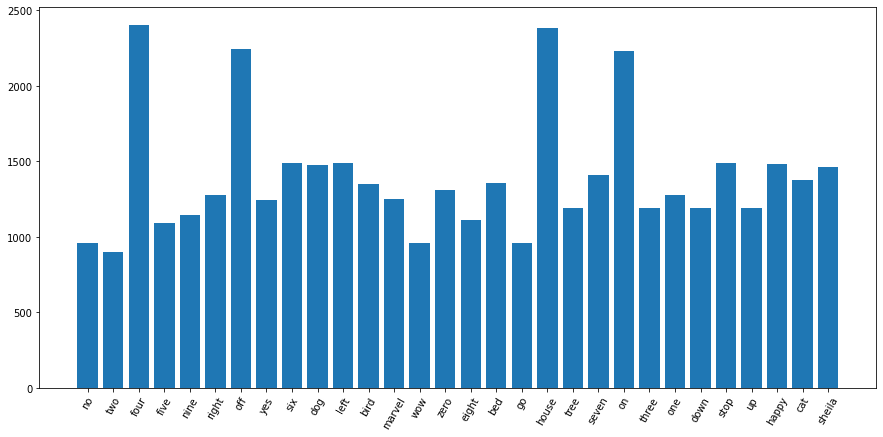

In [8]:

plt.rcParams['figure.figsize']=(15,7)
train_loc='../input/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset'
labels=os.listdir(train_loc)
labels
count_lis=[len(os.listdir(train_loc+'/{}'.format(i))) for i in labels]
index=np.arange(0,len(count_lis))
plt.bar(index,count_lis)
plt.xticks(index,labels,rotation=60)
plt.show()



            
    
    
    

(array([    0.,     0.,     0.,     0.,     0., 41849.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

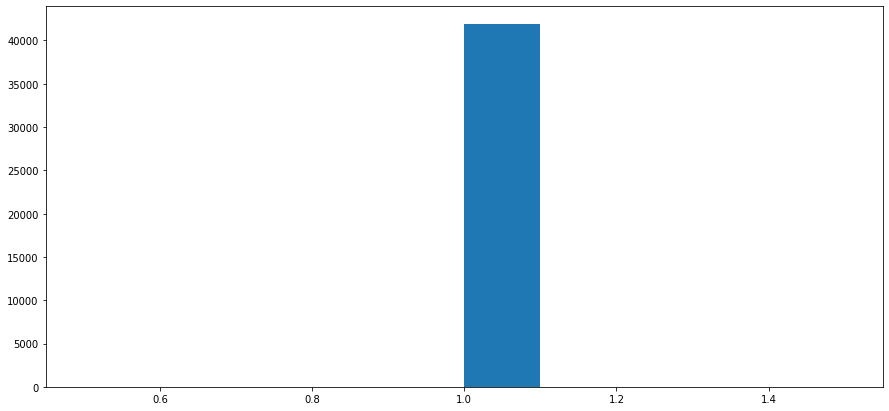

In [19]:

duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_loc + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_loc + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [24]:
# In the data exploration part earlier, we have seen that the duration of a few recordings
# is less than 1 second and the sampling rate is too high. So, let us read the audio waves and 
# use the below-preprocessing steps to deal with this.

# Here are the two steps we’ll follow:

# Resampling
# Removing shorter commands of less than 1 second

In [9]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_loc + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_loc + '/' + label + '/' + wav, sr = 8000)
        #samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

no
two
four
five
nine
right
off
yes
six
dog
left
bird
marvel
wow
zero
eight
bed
go
house
tree
seven
on
three
one
down
stop
up
happy
cat
sheila


In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le=LabelEncoder()
y=le.fit_transform(all_label)
print(y.shape)
classes=list(le.classes_)
y1=np_utils.to_categorical(y, num_classes=len(labels))


(41849,)


In [17]:
y1.shape

(41849, 30)

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(all_wave).reshape(-1,8000,1),np.array(y1),test_size=0.2,shuffle=True)

In [22]:
from tensorflow.keras.layers import Input,Dense,Flatten,Conv1D,MaxPooling1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [23]:
inputs=Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [24]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [27]:
history=model.fit(X_train, y_train ,epochs=50, callbacks=[es,mc], batch_size=32, validation_data=(X_test,y_test))

Epoch 1/50
1047/1047 [==============================] - 11s 7ms/step - loss: 2.8612 - accuracy: 0.1788 - val_loss: 1.3275 - val_accuracy: 0.5823
Epoch 2/50
1047/1047 [==============================] - 7s 7ms/step - loss: 1.4202 - accuracy: 0.5349 - val_loss: 0.8865 - val_accuracy: 0.7171
Epoch 3/50
1047/1047 [==============================] - 7s 7ms/step - loss: 1.0825 - accuracy: 0.6319 - val_loss: 0.7100 - val_accuracy: 0.7846
Epoch 4/50
1047/1047 [==============================] - 8s 7ms/step - loss: 0.8907 - accuracy: 0.6992 - val_loss: 0.6064 - val_accuracy: 0.8043
Epoch 5/50
1047/1047 [==============================] - 7s 7ms/step - loss: 0.7598 - accuracy: 0.7459 - val_loss: 0.4708 - val_accuracy: 0.8489
Epoch 6/50
1047/1047 [==============================] - 7s 7ms/step - loss: 0.6693 - accuracy: 0.7765 - val_loss: 0.4360 - val_accuracy: 0.8654
Epoch 7/50
1047/1047 [==============================] - 7s 7ms/step - loss: 0.5983 - accuracy: 0.7980 - val_loss: 0.3784 - val_accuracy

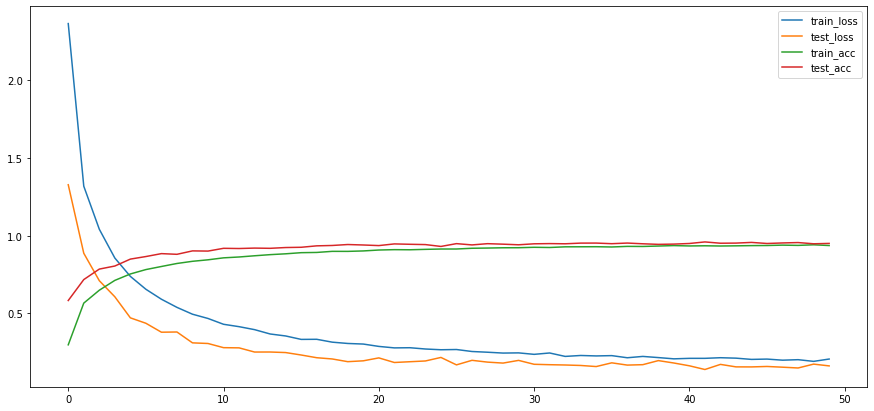

In [29]:
plt.plot(history.history['loss'], label='train_loss') 
plt.plot(history.history['val_loss'], label='test_loss') 
plt.plot(history.history['accuracy'], label='train_acc') 
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend() 
plt.show()

In [ ]:
## function to predict text
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]
import random
index=random.randint(0,len(X_test)-1)
samples=X_test[index].ravel()
print("Audio:",classes[np.argmax(y_test[index])])
a=ipd.Audio(samples, rate=8000)
a
print("Text:",predict(samples))